## Quantum Reinforcement Learning with Cirq and LSTD/DQN Agents

We will implement a quantum reinforcement learning (QRL) environment using realistic qubit simulations in Cirq, and train classical RL agents (LSTD and DQN) to optimize measurement strategies.

We first install the necessary packages:

In [ ]:
# install dependencies
!pip install --upgrade pip
!pip install numpy scipy gym tensorflow keras git+https://github.com/keras-rl/keras-rl.git

In [ ]:
!pip install gymnasium==0.29.1 stable-baselines3[extra]

In [23]:
try:
    import cirq
except ImportError:
    print("Installing cirq...")
    !pip install --quiet cirq
    print("Installed cirq.")

Installing cirq...
Installed cirq.


We define a 3-qubit repetition code environment where the agent can measure stabilizers to correct noise:

- {State:} Qubit states $+$ syndrome of stabilizers.
    {Actions:} Measure stabilizers
    Z_1 Z_2 or Z_2 Z_3 (represented as a binary vector).
     Logical fidelity minus measurement cost.


$\
{Reward} = F_{\text{logical}} \cdot R_{\text{scale}} - \sum_i \text{action}_i
\$

where:
\[
F_{{logical}} =
\begin{cases}
1, & \text{if majority vote matches logical 0} \\
0, & \text{otherwise}
\end{cases}
\]

and $R_{\text{scale}}$ is a scaling factor for the reward

Key methods:

- reset(): Initialize logical qubit |0_L> = |000>

- apply_noise(): Flip each qubit with probability noise_prob

- measure_stabilizers(action): Update syndromes if measured

- step(action): Apply noise, measure stabilizers, compute reward

- get_features(): Return qubit + syndrome as feature vector

In [ ]:
# Standard imports
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce

# ---------------------------
# 2. Quantum Environment
# ---------------------------

class RepetitionQECEnvironment:
    """
    Minimal 3-qubit repetition code environment.
    Actions: binary vector indicating which stabilizers to measure.
    State: syndrome + logical qubit state.
    """
    def __init__(self, noise_prob=0.05, max_steps=5, reward_scale=100):
        self.noise_prob = noise_prob
        self.max_steps = max_steps
        self.reward_scale = reward_scale
        self.reset()

    def reset(self):
        # Logical qubit initialized to |0_L> = |000>
        self.state = np.array([0,0,0], dtype=int)
        self.syndrome = np.array([0,0], dtype=int)  # Two stabilizers Z1Z2, Z2Z3
        self.current_step = 0
        return self.get_features()

    def apply_noise(self):
        for i in range(3):
            if random.random() < self.noise_prob:
                self.state[i] ^= 1  # flip qubit

    def measure_stabilizers(self, action):
        """
        action: [measure Z1Z2?, measure Z2Z3?] -> binary vector
        Update syndrome if measured
        """
        if action[0]:
            self.syndrome[0] = self.state[0] ^ self.state[1]
        if action[1]:
            self.syndrome[1] = self.state[1] ^ self.state[2]

    def logical_fidelity(self):
        """
        Fidelity of logical qubit: 1 if majority vote matches 0
        """
        majority = 1 if sum(self.state) > 1 else 0
        return 1.0 if majority == 0 else 0.0

    def step(self, action):
        self.apply_noise()
        self.measure_stabilizers(action)
        self.current_step += 1
        done = self.current_step >= self.max_steps
        reward = self.logical_fidelity() * self.reward_scale - sum(action)  # penalize measurements
        return reward, self.get_features(), done

    def get_features(self):
        # Concatenate syndrome + qubit states as features
        return np.concatenate((self.state, self.syndrome)).astype(float)

The LSTD agent uses linear function approximation to estimate Q-values:

- {Q-function:}
$\
Q(s,a) = W_a \cdot s
\$

- {Parameters:}  
  num\_actions = number of actions \\
  num\_features = length of feature vector \\
  $\epsilon$ = exploration probability

- {Update Rule:}  
$\
W_a \leftarrow W_a + \alpha \Big( r + \gamma \max_{a'} Q(s',a') - Q(s,a) \Big) s
\$

where:
\[
\begin{aligned}
s   &= \text{current features} \\
s'  &= \text{next features} \\
r   &= \text{reward} \\
\alpha &= \text{learning rate} \\
\gamma &= \text{discount factor}
\end{aligned}
\]

In [ ]:
# ---------------------------
# 3. LSTD Agent
# ---------------------------
class ReplayBuffer:
    def __init__(self):
        self.buffer = []
    def append(self, transition):
        self.buffer.append(transition)
    def sample(self):
        return random.choice(self.buffer)
    def clear(self):
        self.buffer = []

class LSTDAgent:
    """
    LSTD / TD agent for syndrome measurement selection
    Actions: measure each stabilizer or skip
    """
    def __init__(self, num_actions, num_features, step_size=0.01, eps=1.0, num_offline_updates=5):
        self.num_actions = num_actions
        self.num_features = num_features
        self.W = np.zeros((num_actions, num_features))
        self.eps = eps
        self.step_size = step_size
        self.num_offline_updates = num_offline_updates
        self.replay_buffer = ReplayBuffer()
        self.reset()

    def reset(self):
        self.state = None
        self.action = None
        self.replay_buffer.clear()

    def behaviour_policy(self, state):
        if random.random() < self.eps:
            return random.choice(range(self.num_actions))
        else:
            return np.argmax(self.q(state))

    def q(self, state):
        return np.dot(self.W, state)

    def step(self, reward, next_state):
        # Update weights
        s = self.state
        a = self.action
        r = reward
        next_s = next_state
        self.W[a] += self.step_size * (r + np.max(self.q(next_s)) - self.q(s)[a]) * s
        self.replay_buffer.append((s,a,r,next_s))
        for _ in range(self.num_offline_updates):
            s_, a_, r_, next_s_ = self.replay_buffer.sample()
            self.W[a_] += self.step_size * (r_ + np.max(self.q(next_s_)) - self.q(s_)[a_]) * s_
        self.state = next_s
        self.action = self.behaviour_policy(next_s)
        return self.action

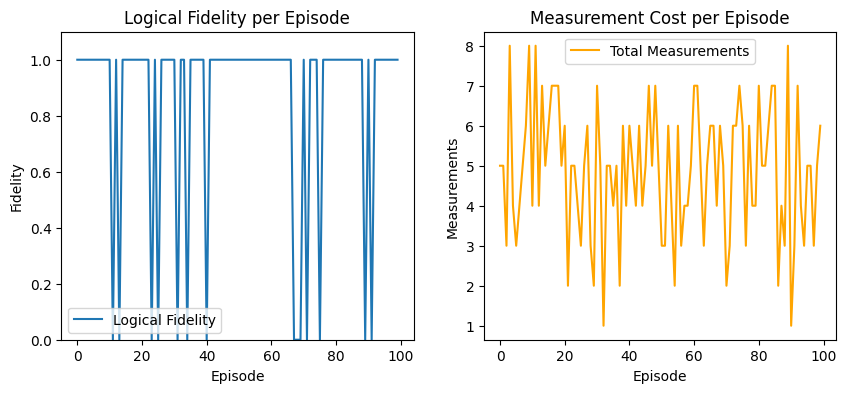

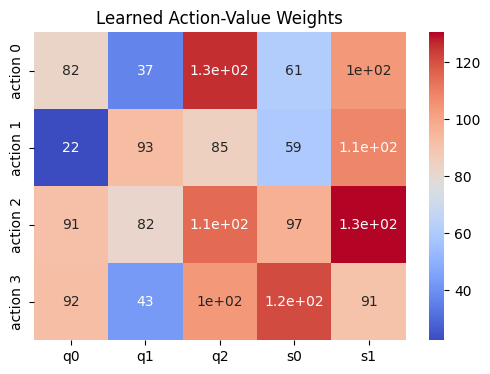

In [29]:

# ---------------------------
# 4. Experiment Runner
# ---------------------------

def action_index_to_binary(action_idx, num_actions=2):
    """Map integer action index to binary vector"""
    return [int(x) for x in format(action_idx, f'0{num_actions}b')]

def run_experiment(episodes=100):
    env = RepetitionQECEnvironment()
    num_actions = 4  # 2 stabilizers -> 2 bits -> 4 possible actions
    num_features = len(env.get_features())
    agent = LSTDAgent(num_actions, num_features)

    fidelity_list = []
    measurements_list = []

    for ep in range(episodes):
        features = env.reset()
        agent.state = features
        agent.action = agent.behaviour_policy(features)
        done = False
        step_count = 0
        while not done:
            action_vec = action_index_to_binary(agent.action)
            reward, next_features, done = env.step(action_vec)
            agent.step(reward, next_features)
            step_count += sum(action_vec)
        fidelity_list.append(env.logical_fidelity())
        measurements_list.append(step_count)

    return fidelity_list, measurements_list, agent.W

# ---------------------------
# 5. Run Training
# ---------------------------
episodes = 100
fidelity, measurements, W = run_experiment(episodes)

# ---------------------------
# 6. Plot Results
# ---------------------------

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(fidelity, label='Logical Fidelity')
plt.xlabel('Episode')
plt.ylabel('Fidelity')
plt.title('Logical Fidelity per Episode')
plt.ylim([0,1.1])
plt.legend()

plt.subplot(1,2,2)
plt.plot(measurements, label='Total Measurements', color='orange')
plt.xlabel('Episode')
plt.ylabel('Measurements')
plt.title('Measurement Cost per Episode')
plt.legend()
plt.show()

# Heatmap of learned weights
plt.figure(figsize=(6,4))
sns.heatmap(W, annot=True, cmap='coolwarm', xticklabels=['q0','q1','q2','s0','s1'], yticklabels=[f'action {i}' for i in range(4)])
plt.title("Learned Action-Value Weights")
plt.show()


We simulate realistic qubits using Cirq:

- State variables:  
  $n_{\text{qubits}} =$ number of qubits \\
  circuit $=$ Cirq circuit to track measurements

- Step function:  
  $\text{step(action)}$ applies measurements, runs the DensityMatrixSimulator, and computes the reward

\[
{reward} = 1 - 0.1 \sum_i a_i
\]

with the condition that at least one measurement is applied to avoid simulator errors.

We implement a simple Q-learning agent for discrete states:

- State variables:  
  $Q$-table stores Q-values for each action  
  $\epsilon =$ probability of taking a random action

- Update rule:  
$\
Q(s,a) \leftarrow Q(s,a) + \alpha \Big[ r + \gamma \max_{a'} Q(s',a') - Q(s,a) \Big]
\$

where $\alpha$ is the learning rate, $\gamma$ the discount factor, $r$ the reward, $s$ the current state, and $s'$ the next state.

We train over n_episodes. Each episode:

- Reset environment: state = env.reset()

- Choose action via policy: action_idx = agent.choose_action(state)

- Convert index to binary action vector

- Take step in environment: reward, next_state, done = env.step(action_vec)

- Update agent: agent.update(action_idx, state, reward, next_state)

We track the agent’s performance using cumulative reward and moving average:

- Cumulative reward at time $t$:  
$\
R_{t}^{\text{cumulative}} = \sum_{i=1}^{t} r_i
\$

- Moving average reward with window size $w$:  
$\
R_{t}^{\text{moving-avg}} = \frac{1}{w} \sum_{i=t-w+1}^{t} r_i
\$


Episode 1: Total reward = 4.90
Episode 2: Total reward = 4.60
Episode 3: Total reward = 4.50
Episode 4: Total reward = 4.60
Episode 5: Total reward = 4.70
Episode 6: Total reward = 4.50
Episode 7: Total reward = 4.50
Episode 8: Total reward = 4.60
Episode 9: Total reward = 4.30
Episode 10: Total reward = 4.50
Episode 11: Total reward = 4.50
Episode 12: Total reward = 4.40
Episode 13: Total reward = 4.70
Episode 14: Total reward = 4.90
Episode 15: Total reward = 4.40
Episode 16: Total reward = 4.80
Episode 17: Total reward = 4.40
Episode 18: Total reward = 4.80
Episode 19: Total reward = 4.20
Episode 20: Total reward = 4.50
Episode 21: Total reward = 4.70
Episode 22: Total reward = 4.30
Episode 23: Total reward = 4.40
Episode 24: Total reward = 4.40
Episode 25: Total reward = 4.60
Episode 26: Total reward = 4.50
Episode 27: Total reward = 4.30
Episode 28: Total reward = 4.20
Episode 29: Total reward = 4.40
Episode 30: Total reward = 4.30
Episode 31: Total reward = 4.50
Episode 32: Total

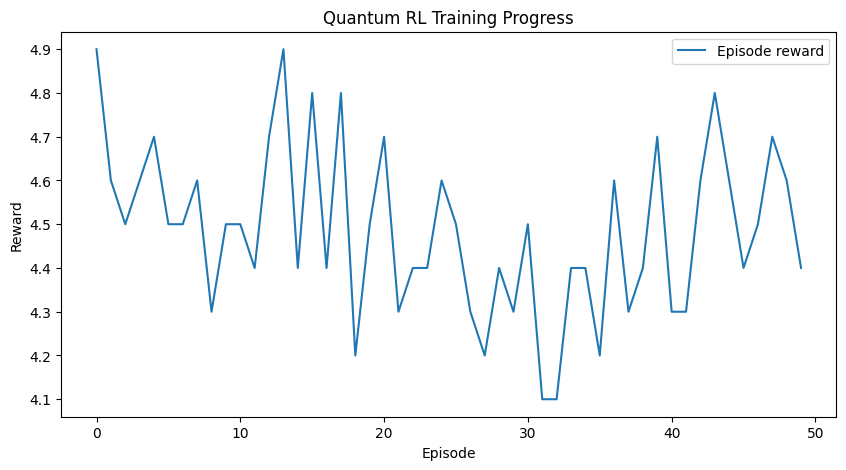

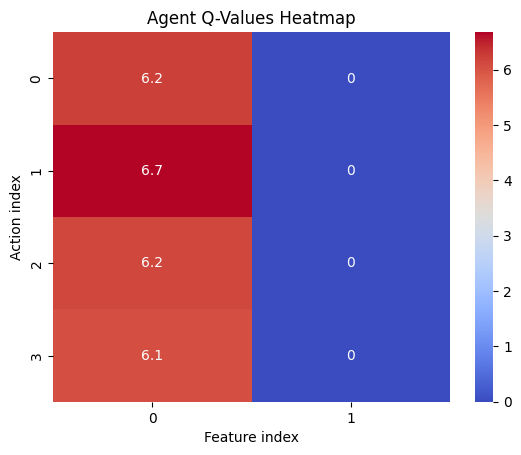

In [32]:
# --- ENVIRONMENT ---
class QuantumEnv:
    def __init__(self, n_qubits=2, max_steps=10, noise_model=None):
        self.n_qubits = n_qubits
        self.qubits = [cirq.LineQubit(i) for i in range(n_qubits)]
        self.max_steps = max_steps
        self.noise_model = noise_model
        self.reset()

    def reset(self):
        self.circuit = cirq.Circuit()
        self.current_step = 0
        # Initialize |0>^n
        self.state_vector = np.zeros(2**self.n_qubits)
        self.state_vector[0] = 1.0
        return self.get_features()

    def get_features(self):
        # For simplicity, features are just zeros vector of length n_qubits
        return np.zeros(self.n_qubits, dtype=np.float32)

    def step(self, action):
        """
        action: list of 0/1 per qubit: 1 means measure this qubit
        """
        # Apply measurements for qubits selected by action
        for i, a in enumerate(action):
            if a:
                key = f'q{i}_step{self.current_step}'  # unique key
                self.circuit.append(cirq.measure(self.qubits[i], key=key))

        self.current_step += 1
        done = self.current_step >= self.max_steps

        # Ensure at least one measurement
        if not any(isinstance(op.gate, cirq.MeasurementGate)
                   for moment in self.circuit
                   for op in moment.operations):
            key = f'dummy_step{self.current_step}'
            self.circuit.append(cirq.measure(self.qubits[0], key=key))

        # Run simulator
        simulator = cirq.DensityMatrixSimulator(noise=self.noise_model)
        result = simulator.run(self.circuit, repetitions=1)

        # Extract measurements
        meas = []
        for i in range(self.n_qubits):
            qubit_meas = []
            for step_idx in range(self.current_step):
                key = f'q{i}_step{step_idx}'
                if key in result.measurements:
                    qubit_meas.append(result.measurements[key][0,0])
            meas.append(sum(qubit_meas) % 2)

        # Reward: fewer measurements = higher reward
        reward = 1.0 - 0.1 * sum(action)

        return reward, self.get_features(), done

# --- AGENT ---
class DQNAgent:
    def __init__(self, n_actions, n_features, eps=0.9, alpha=0.1, gamma=0.95):
        self.n_actions = n_actions
        self.n_features = n_features
        self.eps = eps
        self.alpha = alpha
        self.gamma = gamma
        # Q-table (discrete states): small env, use features as indices
        self.Q = np.zeros((n_actions, n_features))

    def choose_action(self, state):
        if np.random.rand() < self.eps:
            return np.random.randint(self.n_actions)
        q_vals = self.Q[:, 0]  # only one feature per qubit
        return int(np.argmax(q_vals))

    def update(self, action, state, reward, next_state):
        q_predict = self.Q[action, 0]
        q_target = reward + self.gamma * np.max(self.Q[:, 0])
        self.Q[action, 0] += self.alpha * (q_target - q_predict)

# --- HELPER ---
def action_index_to_binary(action_idx, n_qubits):
    return [(action_idx >> i) & 1 for i in range(n_qubits)]

# --- TRAINING LOOP ---
n_qubits = 2
n_actions = 2**n_qubits  # all possible measurement combinations
env = QuantumEnv(n_qubits=n_qubits, max_steps=5)
agent = DQNAgent(n_actions=n_actions, n_features=n_qubits)

n_episodes = 50
all_rewards = []

for ep in range(n_episodes):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        action_idx = agent.choose_action(state)
        action_vec = action_index_to_binary(action_idx, n_qubits)
        reward, next_state, done = env.step(action_vec)
        agent.update(action_idx, state, reward, next_state)
        state = next_state
        total_reward += reward

    all_rewards.append(total_reward)
    print(f"Episode {ep+1}: Total reward = {total_reward:.2f}")

# --- PLOTTING ---
plt.figure(figsize=(10,5))
plt.plot(all_rewards, label="Episode reward")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Quantum RL Training Progress")
plt.legend()
plt.show()

sns.heatmap(agent.Q, annot=True, cmap="coolwarm")
plt.title("Agent Q-Values Heatmap")
plt.xlabel("Feature index")
plt.ylabel("Action index")
plt.show()


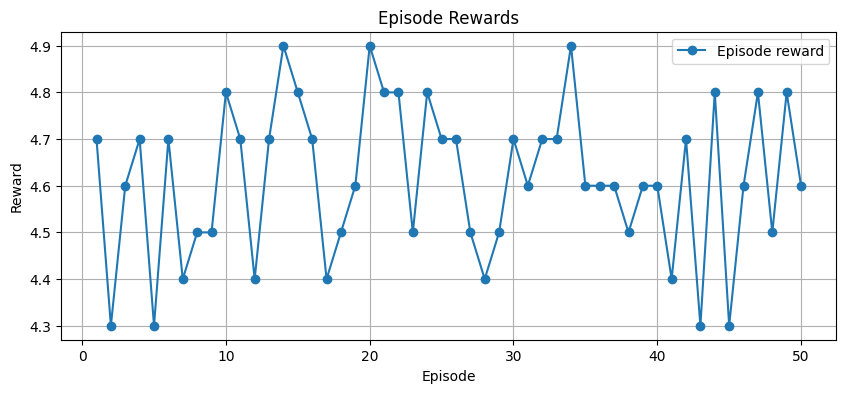

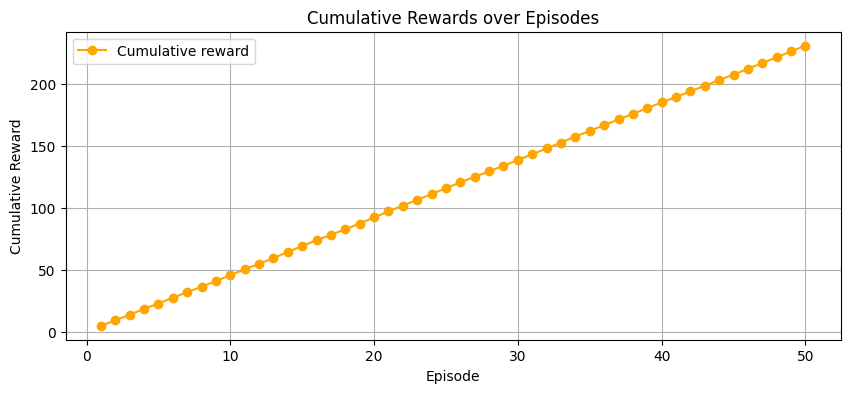

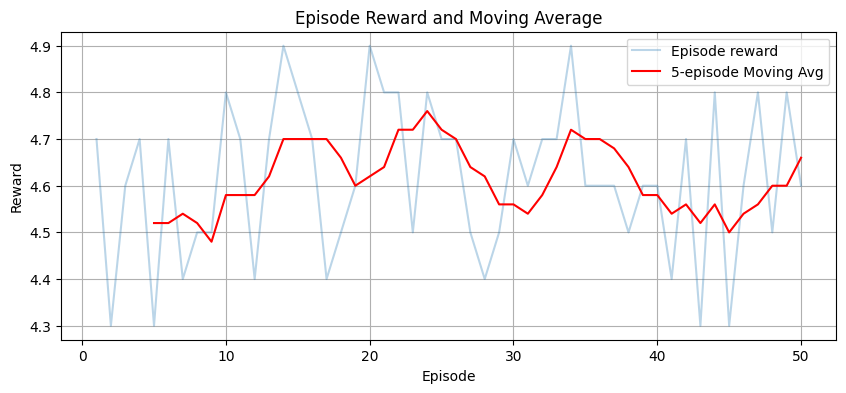

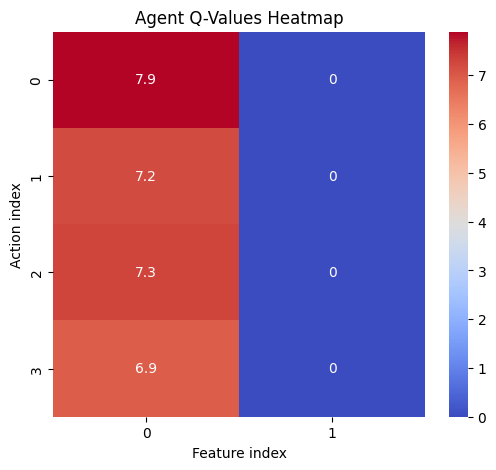

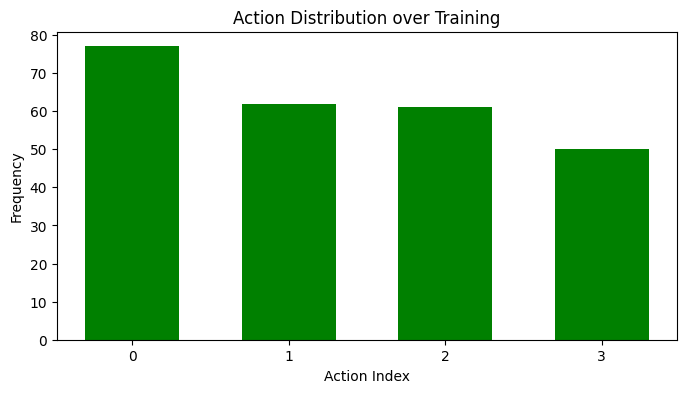

In [34]:
# --- ADDITIONAL PLOTTING ---
import pandas as pd

# Convert rewards to DataFrame for convenience
df = pd.DataFrame({
    'episode': np.arange(1, n_episodes+1),
    'reward': all_rewards
})

# 1️⃣ Episode rewards
plt.figure(figsize=(10,4))
plt.plot(df['episode'], df['reward'], marker='o', label='Episode reward')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Episode Rewards")
plt.grid(True)
plt.legend()
plt.show()

# 2️⃣ Cumulative rewards
df['cumulative_reward'] = df['reward'].cumsum()
plt.figure(figsize=(10,4))
plt.plot(df['episode'], df['cumulative_reward'], marker='o', color='orange', label='Cumulative reward')
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Rewards over Episodes")
plt.grid(True)
plt.legend()
plt.show()

# 3️⃣ Moving average of rewards (window=5)
window = 5
df['moving_avg'] = df['reward'].rolling(window).mean()
plt.figure(figsize=(10,4))
plt.plot(df['episode'], df['reward'], alpha=0.3, label='Episode reward')
plt.plot(df['episode'], df['moving_avg'], color='red', label=f'{window}-episode Moving Avg')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Episode Reward and Moving Average")
plt.grid(True)
plt.legend()
plt.show()

# 4️⃣ Q-value heatmap
plt.figure(figsize=(6,5))
sns.heatmap(agent.Q, annot=True, cmap="coolwarm", cbar=True)
plt.title("Agent Q-Values Heatmap")
plt.xlabel("Feature index")
plt.ylabel("Action index")
plt.show()

# 5️⃣ Action distribution
actions_taken = []
for ep in range(n_episodes):
    state = env.reset()
    done = False
    while not done:
        action_idx = agent.choose_action(state)
        actions_taken.append(action_idx)
        action_vec = action_index_to_binary(action_idx, n_qubits)
        _, state, done = env.step(action_vec)

plt.figure(figsize=(8,4))
plt.hist(actions_taken, bins=np.arange(-0.5, n_actions+0.5, 1), rwidth=0.6, color='green')
plt.xlabel("Action Index")
plt.ylabel("Frequency")
plt.title("Action Distribution over Training")
plt.xticks(range(n_actions))
plt.show()
